In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')

from ipywidgets import IntSlider, interact

%load_ext autoreload
%autoreload 2

# Clustering the whole dataset

In this 3rd notebook, we will divide the whole dataset of ribo and proteins levels into various clusters, hoping to find a cluster of uncorrelated entries.<br/>
We will proceed in 3 parts :
- First of all, we will keep analysing our dataset with various clusterisations using k-Means
- Then, we will study the correlation between ribo and proteins levels within each cluster
- Finally, we will do the same for another clustering methods : Ward (Agglomerative Hierarchical clustering)

### Loading data

In [3]:
# Standardized data (Log2 and z-score)
prot_data = pd.read_csv('data2/data_prot_log2_zscore.csv', index_col=0, header=[0, 1])
ribo_data = pd.read_csv('data2/data_ribo_log2_zscore.csv', index_col=0, header=[0, 1])
data = pd.read_csv('data2/data_log2_zscore.csv', index_col=0, header=[0, 1])

# Log2 data
prot_data_log2 = pd.read_csv('data2/data_prot_log2.csv', index_col=0, header=[0, 1])
ribo_data_log2 = pd.read_csv('data2/data_ribo_log2.csv', index_col=0, header=[0, 1])
data_log2 = pd.read_csv('data2/data_log2.csv', index_col=0, header=[0, 1])

# Diff Log2 data
prot_data_geom = pd.read_csv('data2/data_prot_diff_log2.csv', index_col=0, header=[0, 1])
ribo_data_geom = pd.read_csv('data2/data_ribo_diff_log2.csv', index_col=0, header=[0, 1])
data_geom = pd.read_csv('data2/data_diff_log2.csv', index_col=0, header=[0, 1])

## I - K-means and clusters analysis

In this first part, we divide our data into clusters using the k-Means method.
- In order to get an idea of the behavior of our ribo and proteins, we will first cluster them independently
- Then, we will cluster each entry (including ribo and proteins levels) for several values of k

### a) Functions definition

Let's define a function to learn the model :

In [4]:
def kmeans(df, k):
    kmeans_model = KMeans(n_clusters=k)
    model = kmeans_model.fit(df)
    score = silhouette_score(df, model.labels_)
    return model, score

Now, we define 3 other plot functions in order to visualize our results :
- The first plots the mean of each cluster over time
- The second plots the levels of ribo & proteins for one cluster particular cluster
- The third plots the avergared levels of ribo & proteins over time for one cluster particular cluster

In [5]:
def plot_kmeans_centers(model, n_clust):
    
    xticks_ = [0, 1, 3, 5, 7, 10]
    #xticks_ = [1, 2, 3, 4, 5, 6, 7, 8, 10]
    
    for k in range(n_clust):
        plt.plot(xticks_, model.cluster_centers_[k,:], label='c'+str(k))
        
    plt.xticks(xticks_)
    
    plt.xlabel('Time [h]')
    plt.ylabel('Relative distance of standardized log$_2$ ratio')
    
    plt.legend(loc='best')

In [7]:
def plot_clust(model, df1, df2, l):
    
    xticks_ = [0, 1, 3, 5, 7, 10]
    #xticks_ = [1, 2, 3, 4, 5, 6, 7, 8, 10]
    
    plt.plot(xticks_, df1.iloc[np.where(model.labels_==l)].values.T, color=(1.0,0.0,0.0,0.1))
    plt.plot(xticks_, df2.iloc[np.where(model.labels_==l)].values.T, color=(0.0,0.0,1.0,0.1))
    
    plt.xticks(xticks_)
    
    plt.xlabel('Time [h]')
    plt.ylabel('Standardized log$_2$ ratio')
    
    red = mpatches.Patch(color='red', label='prot')
    blue = mpatches.Patch(color='blue', label='ribo')
    plt.legend(handles=[red,blue], loc='best')

In [6]:
def plot_corr_clust_hist(n_clust, corr_clusters, nbins):

    for k in range(n_clust):
        plt.hist(corr_clusters[k], bins=nbins, label='c'+str(k)+', '+str(len(corr_clusters[k]))+' entries', alpha=0.7)
    
    #plt.hist(corr_clusters, bins=nbins)
    
    plt.legend(loc='best')
    plt.title('Correlation count for '+str(n_clust)+' clusters in '+str(nbins)+' bins')
    plt.xlabel('Correlation between proteins and corresponding ribo')
    plt.ylabel('Count')

### b) Clustering ribo and proteins pairs using relative distance

We now try to find clusters using the relative distance :

In [7]:
rel_dist_data = (ribo_data["ribo"] - prot_data["prot"]).copy()
#rel_dist_data = (ribo_data["ribo"].sub(ribo_data["ribo"].mean(axis=1), axis=0) - prot_data["prot"].sub(prot_data["prot"].mean(axis=1), axis=0)).copy()
rel_dist_data.head()

,h0,h1,h3,h5,h7,h10
SPAC1002.01,2.252440,0.247936,0.766351,-0.186939,-0.183958,-2.895831
SPAC1002.02,0.846783,1.025552,0.666343,-1.853400,-0.360964,-0.324315
SPAC1002.03c,-0.771681,-1.314382,1.228029,0.591237,1.441609,-1.174812
SPAC1002.04c,-1.594082,-0.774792,0.968954,-1.281576,2.273433,0.408063
SPAC1002.07c,1.344468,0.756159,1.265144,-0.111776,-2.046474,-1.207521


We learn the model for several values of k :

In [8]:
kmean_model, kmean_score = {}, {}

k = range(2, 10)

kmean_score = np.zeros(len(k))
for i, n_clust in enumerate(k):
    kmean_model[n_clust], kmean_score[i] = kmeans(rel_dist_data, n_clust)

We can plot the silhouette score as a function of the number of clusters

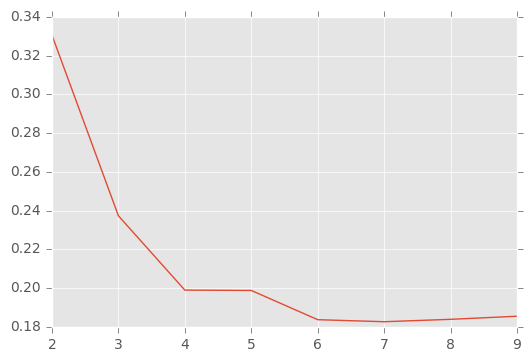

In [9]:
plt.plot(k, kmean_score)
plt.show()

We can see that 3 or 4 clusters is good enough, then, as expected, we have overfitting so the score become slowly better.

Let's plot the clusters centers :

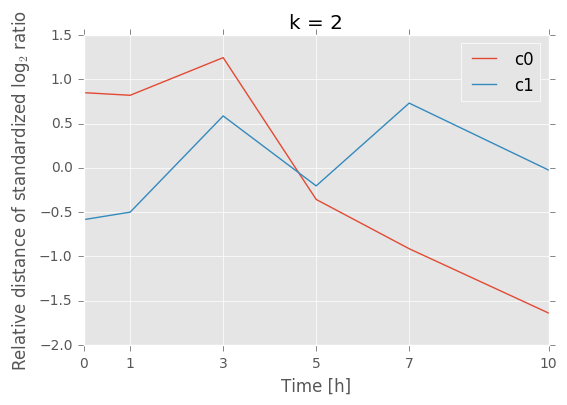

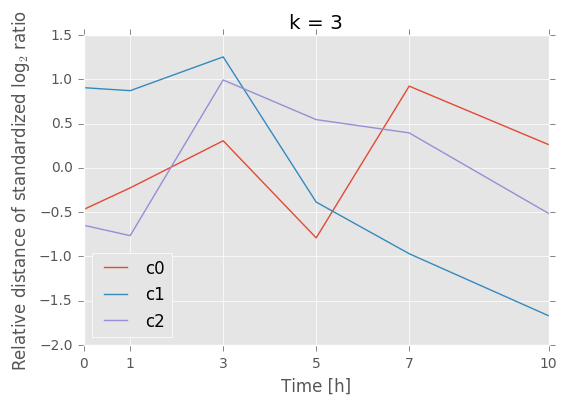

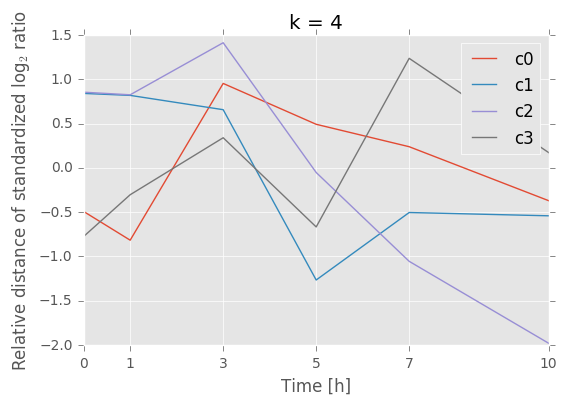

In [10]:
for n_clust in [2, 3, 4]:
    plot_kmeans_centers(kmean_model[n_clust], n_clust)
    plt.title("k = "+str(n_clust))
    plt.show()

Remembre that our relative distance represents *protein levels - ribo level*.<br/>
As an example, for k = 2 : 
- Cluster 0 (red) indicates a descending protein level, or an ascending ribo level, or both of them.
- Cluster 1 (blue) indicates a descending ribo level, or an ascending protein level, or both of them.

In order to visualize the real distribution of the data, we can plot each entry :

In [11]:
n_clust = 3

for k in range(n_clust):
    plot_clust(kmean_model[n_clust], prot_data, ribo_data, k)
    #TODO: plot_clust_distance_rel()

    n_entries = np.sum(kmean_model[n_clust].labels_ == k)
    plt.title(str(n_entries)+' entries in cluster '+str(k))

    plt.show()

NameError: name 'plot_clust' is not defined

## II - Correlation between ribo and proteins level within cluters

Now, it's time to check if we can get some clusters of uncorrelated entries.<br/>
We will study the models based on the relative distance between levels as it gives betters results.

In [42]:
def compute_corr(k):
    return prot_data_log2.iloc[k]["prot"].corr(ribo_data_log2.iloc[k]["ribo"], method='pearson')

We compute the correlation between protein and ribo levels for each entry of each cluster for our various models and plot it

In [43]:
def compute_corr_clust(n_clust, model):
    # For each clusters, compute the correlation for each pairs of prot-ribo
    corr_clust = []
    for l in range(model.labels_.max()+1): # For each cluster in this model
        correl = np.array([])
        for x in np.where(model.labels_ == l)[0]: # For each entry corresponding to this cluster
            correl = np.append(correl, [compute_corr(x)])
        
        corr_clust.append(pd.Series(correl, index=data.index[np.where(model.labels_ == l)]))
        
    return corr_clust
    
# Compute the correlations
corr_clust_kmean = compute_corr_clust(n_clust, kmean_model[n_clust])

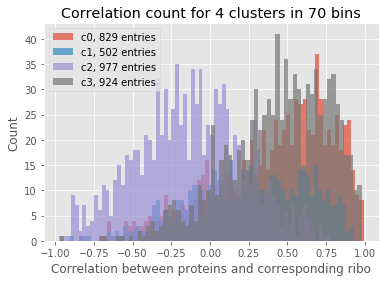

In [44]:
# Plot the result
nbins = 70
plot_corr_clust_hist(n_clust, corr_clust_kmean, nbins)
plt.show()

The correlated entries are separated from the uncorrelated one. The separation is not perfect but can be further improved (see bootstrapping section). Moreover, we have two clusters of uncorrelated data which can be understood biologically and merge if we use the absolute distance instead of the relative distance. So using these facts and the silhouette score, we are fairly confident that choosing 3 clusters is a good assumption.

In [45]:
for k in range(n_clust):
    print('cluster', k, 'mean correlation =', corr_clust_kmean[k].mean())

cluster 0 mean correlation = 0.414183443892
cluster 1 mean correlation = 0.248046900837
cluster 2 mean correlation = -0.128792306827
cluster 3 mean correlation = 0.436028533461


In [23]:
#corr_clust_kmean[0].to_csv("Kmeansprotup.csv")
#corr_clust_kmean[1].to_csv("Kmeanscorr.csv")
#corr_clust_kmean[2].to_csv("KmeansRNAup.csv")

We define a general purpose testing pipeline for the different methods

In [24]:
def testing_pipeline(model, n_clust):
    # Plot the clusters
    for k in range(n_clust):
        plot_clust(model, prot_data, ribo_data, k)

        n_entries = np.sum(model.labels_ == k)
        plt.title(str(n_entries)+' entries in cluster '+str(k))

        plt.show()
        
    # Compute the correlations
    corr_clust = compute_corr_clust(n_clust, model)
        
    # Plot the result
    nbins = 70
    plot_corr_clust_hist(n_clust, corr_clust, nbins)
    plt.show()

### a) Hierarchical clustering
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

#### with ward linkage

Then we find the clusters of n_clust on our relative distance data and test the model

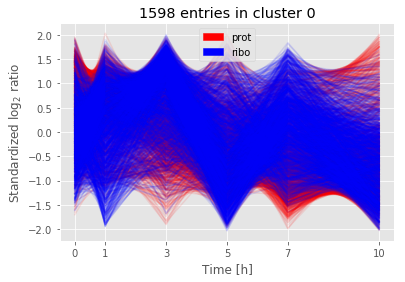

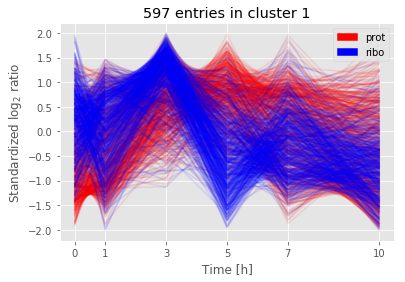

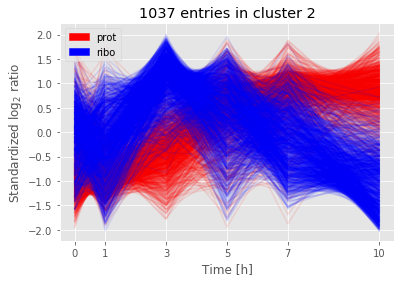

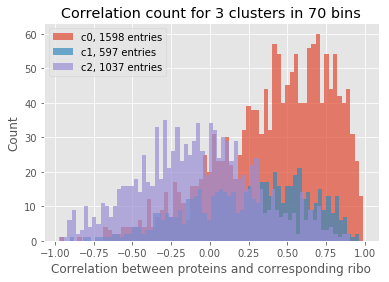

In [25]:
# defining the number of clusters
n_clust = 3

# fit the model
ward_model = AgglomerativeClustering(n_clusters=n_clust, linkage='ward').fit(rel_dist_data)

# Test the model
testing_pipeline(ward_model, n_clust)

#### with complete linkage

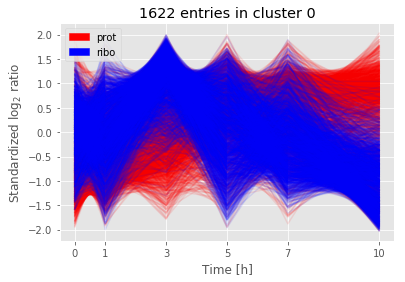

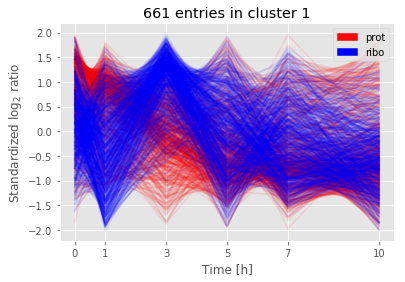

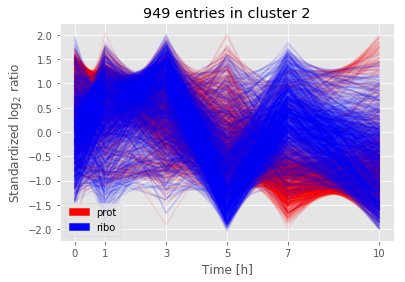

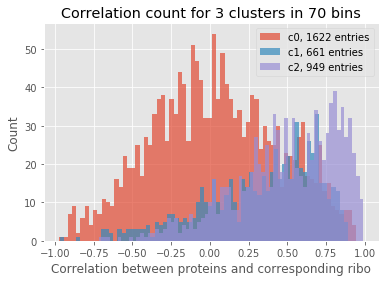

In [26]:
# defining the number of clusters
n_clust = 3

# fit the model
complete_model = AgglomerativeClustering(n_clusters=n_clust, linkage='complete', affinity='l1').fit(rel_dist_data)

# Test the model
testing_pipeline(complete_model, n_clust)

### b) Spectral Clustering
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering

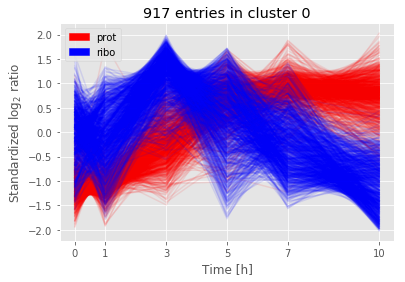

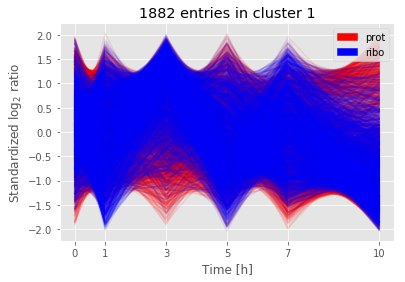

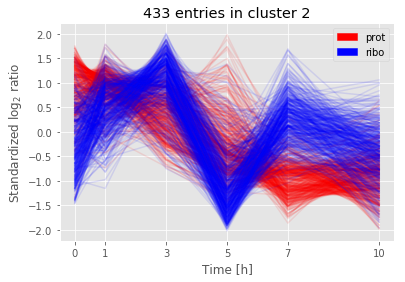

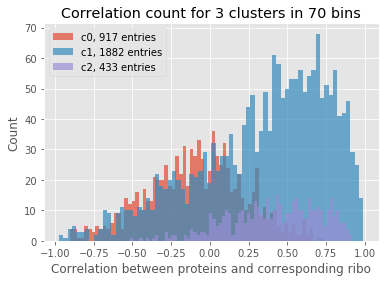

In [27]:
# defining the number of clusters
n_clust = 3

# fit the model
spectral_model = SpectralClustering(n_clusters=n_clust).fit(rel_dist_data)

# Test the model
testing_pipeline(spectral_model, n_clust)

### c) Birch

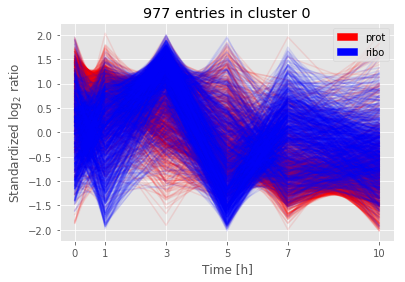

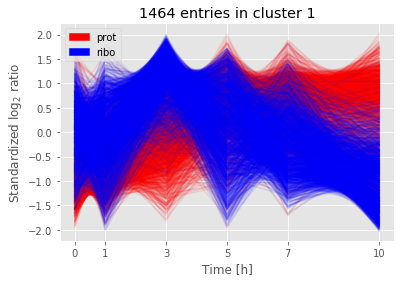

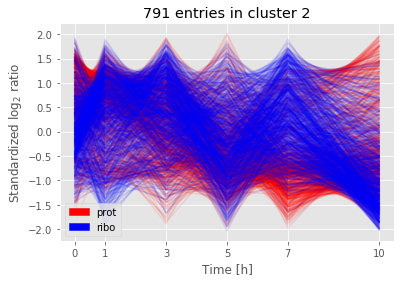

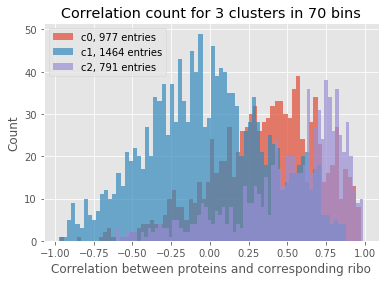

In [28]:
# fit the model
birch_model = Birch().fit(rel_dist_data)

# Test the model
testing_pipeline(birch_model, birch_model.labels_.max()+1)

### d) Mini Batch KMeans


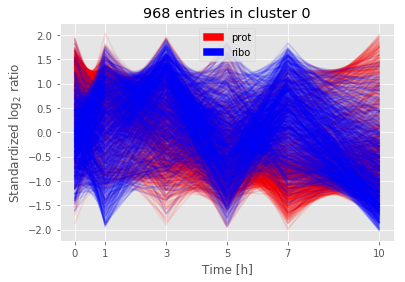

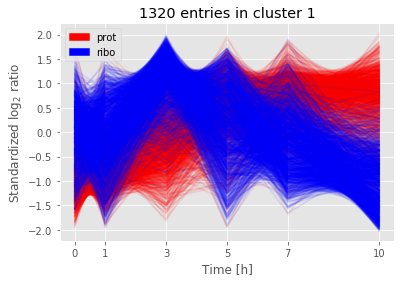

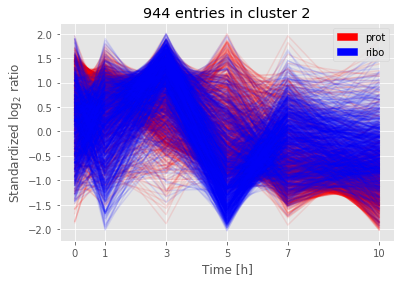

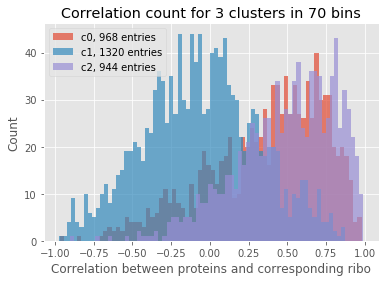

In [29]:
# defining the number of clusters
n_clust = 3

# fit the model
minibatch_model = MiniBatchKMeans(n_clusters=n_clust, batch_size=300).fit(rel_dist_data)

# Test the model
testing_pipeline(minibatch_model, n_clust)

## IV - Bootstrapping

https://en.wikipedia.org/wiki/Bootstrapping_(statistics)

https://en.wikipedia.org/wiki/Bootstrap_aggregating

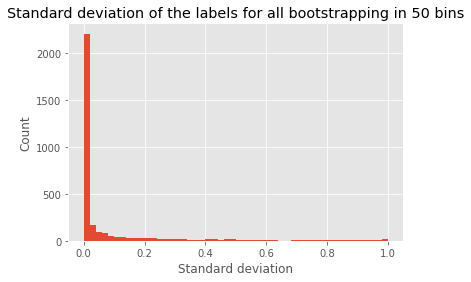

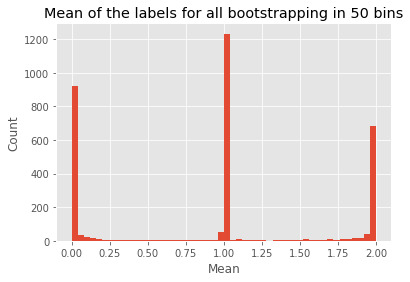

In [30]:
# Choose S from N data entries, M times
M = 50000
S = int(0.9*data.shape[0])
N = data.shape[0]

# Use k-means clustering with 'n_clust' clusters
n_clust = 3

# First k-means
# choose S from N entries
ids = np.random.choice(N, S)

# compute k-means
kmeans_model = KMeans(n_clusters=n_clust)
rel_dist_model_k = kmeans_model.fit(rel_dist_data.iloc[ids])

# save weights
bootst_labels = -np.ones((M,N))
bootst_labels[0,ids] = rel_dist_model_k.labels_

# setup cluster centers
sum_c_centers = rel_dist_model_k.cluster_centers_

# Compute k-means labels for each sub-samples
for k in range(1,M):
    # choose S from N entries
    ids = np.random.choice(N, S)
    
    # compute k-means
    kmeans_model = KMeans(n_clusters=n_clust, init=sum_c_centers/float(k), n_init=1)
    rel_dist_model_k = kmeans_model.fit(rel_dist_data.iloc[ids])
    
    # save weights
    bootst_labels[k,ids] = rel_dist_model_k.labels_
    
    # update c_centers
    sum_c_centers += rel_dist_model_k.cluster_centers_
    
    #if k%10==0:
    #    print('Progress : '+str(k)+' / '+str(M))

# Compute mean and std of m labels available (not -1) for each entries
bootst_labels_means = np.zeros(N)
bootst_labels_stds = np.zeros(N)
for i in range(N):
    bootst_labels_means[i] = bootst_labels[np.where(bootst_labels[:,i] > -1)[0],i].mean()
    bootst_labels_stds[i] = bootst_labels[np.where(bootst_labels[:,i] > -1)[0],i].std()
    
# Plot histogram of standard deviation of the m labels available
nbins = 50
plt.hist(bootst_labels_stds, bins=nbins)
plt.title('Standard deviation of the labels for all bootstrapping in '+str(nbins)+' bins')
plt.xlabel('Standard deviation')
plt.ylabel('Count')
plt.show()

# Plot histogram of mean of the m labels available
nbins = 50
plt.hist(bootst_labels_means, bins=nbins)
plt.title('Mean of the labels for all bootstrapping in '+str(nbins)+' bins')
plt.xlabel('Mean')
plt.ylabel('Count')
plt.show()

### Count and distribution of entries with high bootstrap standard deviation

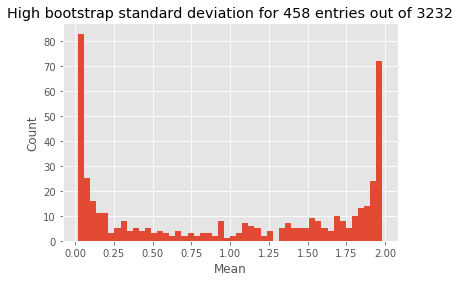

In [31]:
nbins = 50
thr = bootst_labels_stds.std()

plt.hist(bootst_labels_means[bootst_labels_stds > thr], bins=nbins)
plt.title('High bootstrap standard deviation for '+str((bootst_labels_stds > thr).sum())+' entries out of '+str(bootst_labels_stds.shape[0]))
plt.xlabel('Mean')
plt.ylabel('Count')
plt.show()

### Low bootstrap standard deviation

ValueError: x and y must have same first dimension, but have shapes (10,) and (6, 908)

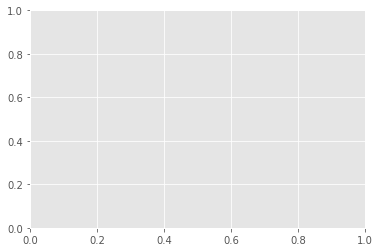

In [32]:
# Threshold parameter
thr = bootst_labels_stds.std()

b_labels = bootst_labels_means.astype(int)
for l in range(n_clust):
    ids = np.where((b_labels == l) & (bootst_labels_stds < thr))[0]
    
    plt.plot(np.arange(10), prot_data.iloc[ids].values.T, color=(1.0,0.0,0.0,0.1))
    plt.plot(np.arange(10), ribo_data.iloc[ids].values.T, color=(0.0,0.0,1.0,0.1))
    
    red = mpatches.Patch(color='red', label='prot')
    blue = mpatches.Patch(color='blue', label='ribo')
    plt.legend(handles=[red,blue], loc='best')
    
    n_entries = ids.shape[0]
    plt.title(str(n_entries)+' entries in cluster '+str(l))
    plt.ylabel('Standardize ratio')
    plt.xlabel('Time [h]')
    plt.xticks([k for k in range(0, 10)], [k for k in range(0, 11) if k!= 9])

    plt.show() 

Analysis of the correlation for data with low bootstrap standard deviation

In [ ]:
# Threshold parameter
thr = bootst_labels_stds.std()

# Compute the correlations
n_clust = 3

# For each clusters, compute the correlation for each pairs of prot-ribo
corr_clust_bootstrap = []
for l in range(n_clust): # For each cluster in this model
    ids = np.where((b_labels == l) & (bootst_labels_stds < thr))[0]
    
    correl = np.array([])
    for x in ids: # For each entry corresponding to this cluster
        correl = np.append(correl, [compute_corr(x)])
    
    corr_clust_bootstrap.append(pd.Series(correl, index=data.index[ids]))

Finally we plot the correlations for each cluster

In [ ]:
nbins = 70

# Plot the correlation for each clusters with low bootstrap standard deviation
plot_corr_clust_hist(n_clust, corr_clust_bootstrap, nbins)

And compare the results with standard kmean clustering

In [ ]:
# Plot the result
nbins = 70
plot_corr_clust_hist(n_clust, corr_clust_kmean, nbins)
plt.show()

Bootstrapping gives a measurement of the accuracy of the K-means clustering algorithm. Data with high bootstrap standard deviation lies on the boundary between clusters and switch from time to time from one cluster to another depending on the sub-data set choosen. The threshold gives a control for soft boundaries between clusters and is between 0 and 1. A lower threshold results in wider undefined boundary between clusters.